# Classifictation model 

In [59]:
%reset -f

In [60]:
checkpoint = []

In [61]:
# Libraries

import os
from PIL import Image
import itertools

import cv2
from skimage import io, color, filters
from skimage.feature import local_binary_pattern
import numpy as np 
import pandas as pd 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import warnings
warnings.filterwarnings('ignore')

print('Modules Successfully Loaded')

Modules Successfully Loaded


## Dataset 

In [62]:
data_dir= "./Multi-class Weather Dataset"
paths = []
labels = []
folds = os.listdir(data_dir)
for fold in folds :
    condition_path = data_dir +"/" + fold
    all_pic = os.listdir(condition_path)
    for each_pic in all_pic:
        each_pic_path = condition_path +"/" + each_pic
        paths.append(each_pic_path)
        labels.append(fold)
        
pseries = pd.Series(paths, name='Picture Path')
lseries = pd.Series(labels, name='Label')

df = pd.concat([pseries, lseries], axis =1)
df.head()

,Picture Path,Label
0,./Multi-class Weather Dataset/Cloudy/cloudy1.jpg,Cloudy
1,./Multi-class Weather Dataset/Cloudy/cloudy10.jpg,Cloudy
2,./Multi-class Weather Dataset/Cloudy/cloudy100...,Cloudy
3,./Multi-class Weather Dataset/Cloudy/cloudy101...,Cloudy
4,./Multi-class Weather Dataset/Cloudy/cloudy102...,Cloudy


In [63]:
# Convert the labels to French
df['Label'] = df['Label'].replace({'Cloudy': 'Nuageux', 'Rain': 'Pluvieux', 'Shine': 'Ensoleillé', 'Sunrise': 'Lever du soleil'})
df

,Picture Path,Label
0,./Multi-class Weather Dataset/Cloudy/cloudy1.jpg,Nuageux
1,./Multi-class Weather Dataset/Cloudy/cloudy10.jpg,Nuageux
2,./Multi-class Weather Dataset/Cloudy/cloudy100...,Nuageux
3,./Multi-class Weather Dataset/Cloudy/cloudy101...,Nuageux
4,./Multi-class Weather Dataset/Cloudy/cloudy102...,Nuageux
...,...,...
1120,./Multi-class Weather Dataset/Sunrise/sunrise9...,Lever du soleil
1121,./Multi-class Weather Dataset/Sunrise/sunrise9...,Lever du soleil
1122,./Multi-class Weather Dataset/Sunrise/sunrise9...,Lever du soleil
1123,./Multi-class Weather Dataset/Sunrise/sunrise9...,Lever du soleil


In [64]:

# Function to get image dimensions
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height 

# Add columns to dataframe
df['width'], df['height'] = zip(*df['Picture Path'].map(get_image_dimensions))

df.head()

,Picture Path,Label,width,height
0,./Multi-class Weather Dataset/Cloudy/cloudy1.jpg,Nuageux,600,400
1,./Multi-class Weather Dataset/Cloudy/cloudy10.jpg,Nuageux,271,186
2,./Multi-class Weather Dataset/Cloudy/cloudy100...,Nuageux,259,194
3,./Multi-class Weather Dataset/Cloudy/cloudy101...,Nuageux,338,149
4,./Multi-class Weather Dataset/Cloudy/cloudy102...,Nuageux,800,377


# Train Test Split (80% - 20%)

In [65]:
train_set, test_set = train_test_split(df, test_size=0.2, shuffle=True, stratify=df["Label"], random_state=42)

In [66]:
train_set.head()

,Picture Path,Label,width,height
646,./Multi-class Weather Dataset/Shine/shine217.jpg,Ensoleillé,270,169
892,./Multi-class Weather Dataset/Sunrise/sunrise2...,Lever du soleil,3200,1200
157,./Multi-class Weather Dataset/Cloudy/cloudy240...,Nuageux,300,138
682,./Multi-class Weather Dataset/Shine/shine25.jpg,Ensoleillé,852,480
224,./Multi-class Weather Dataset/Cloudy/cloudy300...,Nuageux,300,149


In [67]:
test_set.head()

,Picture Path,Label,width,height
412,./Multi-class Weather Dataset/Rain/rain20.jpg,Pluvieux,620,413
645,./Multi-class Weather Dataset/Shine/shine216.jpg,Ensoleillé,230,153
90,./Multi-class Weather Dataset/Cloudy/cloudy180...,Nuageux,261,175
717,./Multi-class Weather Dataset/Shine/shine53.jpg,Ensoleillé,284,177
393,./Multi-class Weather Dataset/Rain/rain183.jpg,Pluvieux,630,446


# Image Data generator

In [68]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

print("Train Set:")
train_gen = tr_gen.flow_from_dataframe(train_set, x_col='Picture Path', y_col='Label', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)


print("Test Set:")
test_gen = ts_gen.flow_from_dataframe(test_set, x_col='Picture Path', y_col='Label', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Train Set:
Found 900 validated image filenames belonging to 4 classes.
Test Set:
Found 225 validated image filenames belonging to 4 classes.


# Caracteristiques

In [69]:
def resize_and_crop_top(path, new_width=507, new_height=335):
    """
    Resize the image to the specified dimensions and keep only the top 70% of the image.
    
    Args:
    - image: numpy array representing the image.
    - new_width: desired width after resizing.
    - new_height: desired height after resizing.
    
    Returns:
    - Resized and cropped image.
    """
    image = io.imread(path)
    # Resize the image to the desired dimensions without interpolation
    resized_image = cv2.resize(image, (new_width, new_height))
    
    # Calculate the new height to keep only the top 70%
    cropped_height = int(new_height * 0.7)
    
    # Crop the image to keep only the top 70%
    cropped_image = resized_image[:cropped_height, :]
    
    return cropped_image

In [70]:

def resize_images(folder_path, target_size):

    # Parcourir toutes les images dans le dossier
    for filename in os.listdir(folder_path):
        if filename is not None:
            image_path = os.path.join(folder_path, filename)
            
            # Vérifier si le fichier est une image
            if os.path.isfile(image_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp',)) :
                
                # Charger l'image
                image = cv2.imread(image_path)

                # Vérifier si l'image est correctement chargée
                if image is not None:
                    # Redimensionner l'image à la nouvelle taille
                    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
                    
                    # Enregistrer l'image redimensionnée
                    cv2.imwrite(image_path, resized_image)
                else:
                    print(f"Impossible de charger l'image : {image_path}")

    print("Toutes les images ont été redimensionnées avec succès.")

In [71]:
def get_luminance(image):
    # Check if the image has an alpha channel
    if image.shape[2] == 4:
        # Remove the alpha channel
        image = image[:, :, :3]
    gray_image = color.rgb2gray(image)
    luminance_mean = np.std(gray_image)
    return luminance_mean  


def get_histogram(image):
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    # Calculate marginal histograms
    red_hist, red_bins = np.histogram(red_channel.ravel(), bins=256)
    green_hist, green_bins = np.histogram(green_channel.ravel(), bins=256)
    blue_hist, blue_bins = np.histogram(blue_channel.ravel(), bins=256)

    # Calculate the means of each channel
    red_mean = np.average(red_bins[:-1], weights=red_hist)
    green_mean = np.average(green_bins[:-1], weights=green_hist)
    blue_mean = np.average(blue_bins[:-1], weights=blue_hist)

    return [red_mean, green_mean, blue_mean]


In [72]:
def calculate_lbp_histogram(image, n_points=8, radius=1, method='uniform'):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculate LBP patterns
    lbp = local_binary_pattern(image, n_points, radius, method)

    # Calculate the histogram of LBP patterns
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    
    return hist.tolist()


In [73]:
# preprocess + process

def calculate_luminance(path):
    try:
        img = resize_and_crop_top(path)
        return get_luminance(img)
    except Exception as e:
        print(f"Error calculating luminance for image {path}: {str(e)}")
        return None

def calculate_histogram(path):
    try:
        img = resize_and_crop_top(path)
        return get_histogram(img)
    except Exception as e:
        print(f"Error calculating histogram for image {path}: {str(e)}")
        return None

def calculate_LBP(path):
    try:
        img = resize_and_crop_top(path)
        return calculate_lbp_histogram(img, n_points=8, radius=1, method='uniform')
    except Exception as e:
        print(f"Error calculating LBP for image {path}: {str(e)}")
        return None


In [74]:
# Save 

train_set['Luminance'] = None  
train_set['RGB'] = None
train_set['LBP'] = None

for i in range(len(train_set)):
    path = train_set['Picture Path'].iloc[i]
    lumin = calculate_luminance(path)
    hist = calculate_histogram(path)
    lbp = calculate_LBP(path)
    train_set['Luminance'].iloc[i] = lumin
    train_set['RGB'].iloc[i] = hist
    train_set['LBP'].iloc[i] = lbp


Error calculating luminance for image ./Multi-class Weather Dataset/Shine/shine131.jpg: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:3699: error: (-215:Assertion failed) !dsize.empty() in function 'cv::hal::resize'

Error calculating histogram for image ./Multi-class Weather Dataset/Shine/shine131.jpg: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:3699: error: (-215:Assertion failed) !dsize.empty() in function 'cv::hal::resize'

Error calculating LBP for image ./Multi-class Weather Dataset/Shine/shine131.jpg: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:3699: error: (-215:Assertion failed) !dsize.empty() in function 'cv::hal::resize'

Error calculating luminance for image ./Multi-class Weather Dataset/Cloudy/cloudy66.jpg: tuple index out of range
Error calculating histogram for image ./Multi-class Weather Dataset/Cloudy/cloudy66.jpg: too many indices for array: array i

In [75]:
test_set['Luminance'] = None  
test_set['RGB'] = None
test_set['LBP'] = None

for i in range(len(test_set)):
    path = test_set['Picture Path'].iloc[i]
    lumin = calculate_luminance(path)
    hist = calculate_histogram(path)
    lbp = calculate_LBP(path)
    test_set['Luminance'].iloc[i] = lumin
    test_set['RGB'].iloc[i] = hist
    test_set['LBP'].iloc[i] = lbp


Error calculating luminance for image ./Multi-class Weather Dataset/Cloudy/cloudy71.jpg: tuple index out of range
Error calculating histogram for image ./Multi-class Weather Dataset/Cloudy/cloudy71.jpg: too many indices for array: array is 2-dimensional, but 3 were indexed
Error calculating LBP for image ./Multi-class Weather Dataset/Cloudy/cloudy71.jpg: OpenCV(4.8.1) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xd8611878::Set<1,-1,-1>,struct cv::impl::A0xd8611878::Set<0,2,5>,3>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1



In [76]:
train_set = train_set.dropna()
test_set = test_set.dropna()
#train_set.to_csv('train_set.csv', index=False)
#test_set.to_csv('test_set.csv', index=False)

In [77]:
train_set.head()

,Picture Path,Label,width,height,Luminance,RGB,LBP
646,./Multi-class Weather Dataset/Shine/shine217.jpg,Ensoleillé,270,169,0.222895,"[65.78350459354296, 123.6077803380873, 157.317...","[975, 3516, 2790, 15257, 27956, 28952, 7851, 7..."
892,./Multi-class Weather Dataset/Sunrise/sunrise2...,Lever du soleil,3200,1200,0.192201,"[124.46965440562889, 63.85506010800713, 28.894...","[7105, 8965, 4416, 10314, 13292, 17099, 8923, ..."
157,./Multi-class Weather Dataset/Cloudy/cloudy240...,Nuageux,300,138,0.093878,"[108.03152604983227, 108.03152604983227, 108.0...","[255, 1697, 1105, 13024, 31898, 35377, 7565, 6..."
682,./Multi-class Weather Dataset/Shine/shine25.jpg,Ensoleillé,852,480,0.21004,"[100.06668411075077, 131.0842690843153, 167.38...","[2497, 4193, 1729, 11196, 11722, 36659, 11868,..."
224,./Multi-class Weather Dataset/Cloudy/cloudy300...,Nuageux,300,149,0.243915,"[147.60495053097446, 163.75665245852932, 187.3...","[437, 2155, 1398, 12525, 25460, 31878, 7130, 6..."


# Classifier 

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train_rgb = np.array(train_set['RGB'].values.tolist())
X_train_lbp = np.array(train_set['LBP'].values.tolist())
X_train_luminance = np.array(train_set['Luminance'].values.tolist())

X_train = np.column_stack((X_train_rgb, X_train_lbp, X_train_luminance))
y_train = train_set['Label']

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
# knn = KNeighborsClassifier(n_neighbors=5, metric='mahalanobis', metric_params={'V': np.cov(X_train, rowvar=False)})
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

In [79]:
X_test_rgb = np.array(test_set['RGB'].values.tolist())
X_test_lbp = np.array(test_set['LBP'].values.tolist())
X_test_luminance = np.array(test_set['Luminance'].values.tolist())

X_test = np.column_stack((X_test_rgb, X_test_lbp, X_test_luminance))
y_test = test_set['Label']

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6517857142857143
Classification Report:
                 precision    recall  f1-score   support

     Ensoleillé       0.45      0.55      0.50        51
Lever du soleil       0.67      0.63      0.65        71
        Nuageux       0.76      0.69      0.73        59
       Pluvieux       0.78      0.74      0.76        43

       accuracy                           0.65       224
      macro avg       0.67      0.66      0.66       224
   weighted avg       0.67      0.65      0.66       224



In [80]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)


F1 Score: 0.6569408400143437


In [81]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)


[[28 13  6  4]
 [18 45  6  2]
 [12  3 41  3]
 [ 4  6  1 32]]


In [82]:
train_set["Label"].value_counts()

Lever du soleil    286
Nuageux            239
Ensoleillé         201
Pluvieux           171
Name: Label, dtype: int64

[Text(0, 0.5, 'Lever du soleil'),
 Text(0, 1.5, 'Nuageux'),
 Text(0, 2.5, 'Ensoleillé'),
 Text(0, 3.5, 'Pluvieux')]

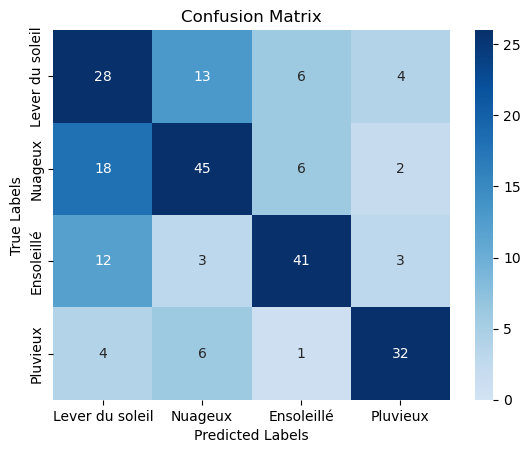

In [83]:
import seaborn as sns
ax = plt.subplot()
sns.heatmap(cm, vmin=0, vmax=26, center=10, cmap=plt.cm.Blues, annot=True)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Lever du soleil', 'Nuageux', "Ensoleillé", 'Pluvieux'])
ax.yaxis.set_ticklabels(['Lever du soleil', 'Nuageux', "Ensoleillé", 'Pluvieux'])

In [84]:
import json

# Define the checkpoint data
checkpoint_data = {
    'model_name': 'K-Nearest Neighbors',
    'features': ['RGB', 'LBP', 'Luminance'],
    'model_parameters': knn.get_params(),
    'accuracy': accuracy,
    'results': classification_report(y_test, y_pred, output_dict=True)
}

checkpoint.append(checkpoint_data)

print("Checkpoint saved successfully.")

Checkpoint saved successfully.


### Interpretation 
***
Le Lever de soleil est une periode de la journee ou elle peut etre nuageux ensoleille ou pluvieux, d'ou la confusion et les resultats non précis sur cette claasse

# Gradient Boost classifier 

In [85]:
from sklearn.ensemble import GradientBoostingClassifier

X_train_rgb = np.array(train_set['RGB'].values.tolist())
X_train_lbp = np.array(train_set['LBP'].values.tolist())
X_train_luminance = np.array(train_set['Luminance'].values.tolist())
X_train = np.column_stack((X_train_rgb, X_train_lbp, X_train_luminance))
y_traX_train = test_set['Label']

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0)
gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=0)

In [86]:
X_test_rgb = np.array(test_set['RGB'].values.tolist())
X_test_lbp = np.array(test_set['LBP'].values.tolist())
X_test_luminance = np.array(test_set['Luminance'].values.tolist())

X_test = np.column_stack((X_test_rgb, X_test_lbp, X_test_luminance))
y_test = test_set['Label']


y_pred = gb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8883928571428571
Classification Report:
                 precision    recall  f1-score   support

     Ensoleillé       0.95      0.76      0.85        51
Lever du soleil       0.92      0.99      0.95        71
        Nuageux       0.87      0.88      0.87        59
       Pluvieux       0.81      0.88      0.84        43

       accuracy                           0.89       224
      macro avg       0.89      0.88      0.88       224
   weighted avg       0.89      0.89      0.89       224



In [87]:
checkpoint_data = {
    'model_name': 'Gradient Boosting Classifier',
    'features': ['RGB', 'LBP', 'Luminance'],
    'model_parameters': gb.get_params(),
    'accuracy': accuracy,
    'results': classification_report(y_test, y_pred, output_dict=True)
}

checkpoint.append(checkpoint_data)

print("Checkpoint saved successfully.")

Checkpoint saved successfully.


[Text(0.5, 0, 'Lever du soleil'),
 Text(1.5, 0, 'Nuageux'),
 Text(2.5, 0, 'Ensoleillé'),
 Text(3.5, 0, 'Pluvieux')]

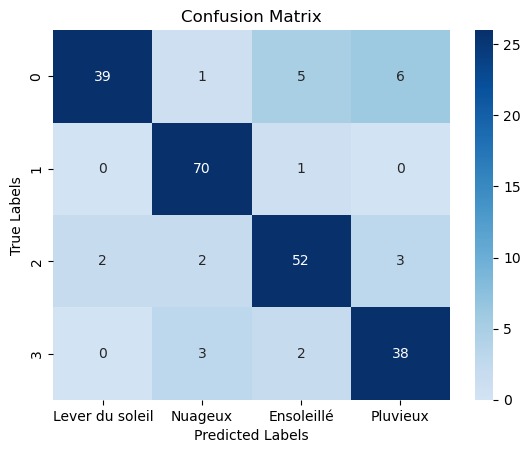

In [88]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, vmin=0, vmax=26, center=10, cmap=plt.cm.Blues, annot=True)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Lever du soleil', 'Nuageux', "Ensoleillé", 'Pluvieux'])

## Random Forest 

In [89]:
from sklearn.ensemble import RandomForestClassifier

X_train_rgb = np.array(train_set['RGB'].values.tolist())
X_train_lbp = np.array(train_set['LBP'].values.tolist())
X_train_luminance = np.array(train_set['Luminance'].values.tolist())
X_train = np.column_stack((X_train_rgb, X_train_lbp, X_train_luminance))
y_train = train_set['Label']

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

In [90]:
X_test_rgb = np.array(test_set['RGB'].values.tolist())
X_test_lbp = np.array(test_set['LBP'].values.tolist())
X_test_luminance = np.array(test_set['Luminance'].values.tolist())

X_test = np.column_stack((X_test_rgb, X_test_lbp, X_test_luminance))
y_test = test_set['Label']


y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8794642857142857
Classification Report:
                 precision    recall  f1-score   support

     Ensoleillé       0.89      0.76      0.82        51
Lever du soleil       0.91      1.00      0.95        71
        Nuageux       0.88      0.83      0.85        59
       Pluvieux       0.83      0.88      0.85        43

       accuracy                           0.88       224
      macro avg       0.87      0.87      0.87       224
   weighted avg       0.88      0.88      0.88       224



[Text(0.5, 0, 'Lever du soleil'),
 Text(1.5, 0, 'Nuageux'),
 Text(2.5, 0, 'Ensoleillé'),
 Text(3.5, 0, 'Pluvieux')]

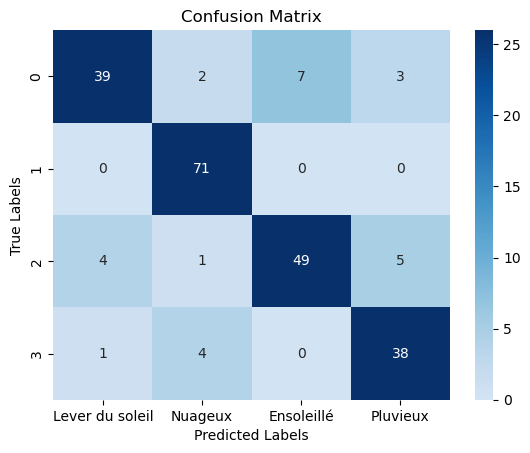

In [91]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, vmin=0, vmax=26, center=10, cmap=plt.cm.Blues, annot=True)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Lever du soleil', 'Nuageux', "Ensoleillé", 'Pluvieux'])

In [92]:
checkpoint_data = {
    'model_name': 'Random Forest Classifier',
    'features': ['RGB', 'LBP', 'Luminance'],
    'model_parameters': rf.get_params(),
    'accuracy': accuracy,
    'results': classification_report(y_test, y_pred, output_dict=True)
}

checkpoint.append(checkpoint_data)

print("Checkpoint saved successfully.")

Checkpoint saved successfully.


# Features Selection
***
Luminance + HSV

In [93]:
def histogram_hsv(image):
    # Convertir l'image RGB en HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculer l'histogramme pour chaque canal (Hue, Saturation, Value)
    h_hist = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    s_hist = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    v_hist = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])

    # Calculer les moyennes de chaque canal
    h_mean = np.average(np.arange(256), weights=h_hist.ravel())
    s_mean = np.average(np.arange(256), weights=s_hist.ravel())
    v_mean = np.average(np.arange(256), weights=v_hist.ravel())

    return [h_mean, s_mean]

def calculate_hsv(path):
    try:
        img = resize_and_crop_top(path)
        return histogram_hsv(img)
    except Exception as e:
        print(f"Error calculating luminance for image {path}: {str(e)}")
        return None

In [94]:
train_set['HSV'] = None  

for i in range(len(train_set)):
    path = train_set['Picture Path'].iloc[i]
    hsv =  calculate_hsv(path)
    train_set['HSV'].iloc[i] = hsv

In [95]:
test_set['HSV'] = None  

for i in range(len(test_set)):
    path = test_set['Picture Path'].iloc[i]
    hsv =  calculate_hsv(path)
    test_set['HSV'].iloc[i] = hsv

In [96]:
%reset -X_train, X_test, y_train, y_test, y_pred, accuracy, f1, cm

UsageError: option -X not recognized ( allowed: "sf" aggressive)


In [97]:
X_train_hsv = np.array(train_set['HSV'].values.tolist())
X_train_rgb = np.array(train_set['RGB'].values.tolist())
X_train_lbp = np.array(train_set['LBP'].values.tolist())
X_train_luminance = np.array(train_set['Luminance'].values.tolist())

X_train = np.column_stack((X_train_hsv, X_train_luminance))
y_train = train_set['Label']

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
# knn = KNeighborsClassifier(n_neighbors=5, metric='mahalanobis', metric_params={'V': np.cov(X_train, rowvar=False)})
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

In [98]:
X_test_hsv = np.array(test_set['HSV'].values.tolist())
X_test_rgb = np.array(test_set['RGB'].values.tolist())
X_test_lbp = np.array(test_set['LBP'].values.tolist())
X_test_luminance = np.array(test_set['Luminance'].values.tolist())

X_test = np.column_stack((X_test_hsv, X_test_luminance))
y_test = test_set['Label']

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6830357142857143
Classification Report:
                 precision    recall  f1-score   support

     Ensoleillé       0.61      0.75      0.67        51
Lever du soleil       0.90      0.89      0.89        71
        Nuageux       0.61      0.59      0.60        59
       Pluvieux       0.49      0.40      0.44        43

       accuracy                           0.68       224
      macro avg       0.65      0.66      0.65       224
   weighted avg       0.68      0.68      0.68       224



[Text(0, 0.5, 'Lever du soleil'),
 Text(0, 1.5, 'Nuageux'),
 Text(0, 2.5, 'Ensoleillé'),
 Text(0, 3.5, 'Pluvieux')]

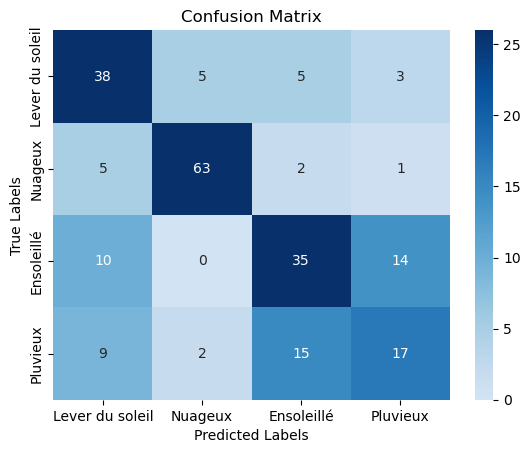

In [99]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, vmin=0, vmax=26, center=10, cmap=plt.cm.Blues, annot=True)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Lever du soleil', 'Nuageux', "Ensoleillé", 'Pluvieux'])
ax.yaxis.set_ticklabels(['Lever du soleil', 'Nuageux', "Ensoleillé", 'Pluvieux'])

In [100]:
import json

# Define the checkpoint data
checkpoint_data = {
    'model_name': 'K-Nearest Neighbors',
    'features': ['RGB', 'LBP', 'Luminance', 'HSV'],
    'model_parameters': knn.get_params(),
    'accuracy': accuracy,
    'results': classification_report(y_test, y_pred, output_dict=True)
}

checkpoint.append(checkpoint_data)

print("Checkpoint saved successfully.")


Checkpoint saved successfully.


## K-Fold

In [107]:
""""
df['Luminance'] = None  
df['RGB'] = None
df['LBP'] = None
df['HSV'] = None

for i in range(len(df)):
    path = df['Picture Path'].iloc[i]
    lumin = calculate_luminance(path)
    hist = calculate_histogram(path)
    lbp = calculate_LBP(path)
    hsv= calculate_hsv(path)
    df['Luminance'].iloc[i] = lumin
    df['RGB'].iloc[i] = hist
    df['LBP'].iloc[i] = lbp
    df['HSV'].iloc[i] = hsv
"""
df = pd.read_csv('dataset_caracteristiques.csv')

In [108]:
# drop None values
df = df.dropna()
#df.to_csv('dataset_caracteristiques.csv', index=False)
df.head()

,Picture Path,Label,width,height,Luminance,RGB,LBP,HSV
0,./Multi-class Weather Dataset/Cloudy/cloudy1.jpg,Nuageux,600,400,0.178594,"[126.34504885660581, 126.34504885660581, 126.3...","[451, 2006, 1591, 15454, 34446, 33885, 9137, 6...","[0.0, 0.0]"
1,./Multi-class Weather Dataset/Cloudy/cloudy10.jpg,Nuageux,271,186,0.118810,"[152.9002701495305, 169.04855283246093, 198.54...","[189, 1748, 894, 11282, 31090, 39998, 7514, 65...","[109.50477081542171, 60.599630809689984]"
2,./Multi-class Weather Dataset/Cloudy/cloudy100...,Nuageux,259,194,0.134323,"[150.96056491174835, 153.7316055129364, 155.91...","[816, 3787, 2685, 13576, 36313, 31807, 7939, 5...","[92.744845664964, 54.62629174463494]"
3,./Multi-class Weather Dataset/Cloudy/cloudy101...,Nuageux,338,149,0.126442,"[171.27977071005918, 177.1194305365903, 200.47...","[285, 1755, 1077, 13818, 29452, 38865, 8806, 7...","[123.27952258129773, 40.92878335777744]"
4,./Multi-class Weather Dataset/Cloudy/cloudy102...,Nuageux,800,377,0.190307,"[133.36938839157773, 145.10622021532942, 168.6...","[1314, 3819, 2962, 15665, 32156, 29125, 10206,...","[109.98722163219205, 57.693647903707074]"


### K-Fold KNN

In [104]:
from sklearn.model_selection import KFold

X_rgb = np.array(df['RGB'].values.tolist())
X_lbp = np.array(df['LBP'].values.tolist())
X_luminance = np.array(df['Luminance'].values.tolist())
X_hsv = np.array(df['HSV'].values.tolist())

X = np.column_stack((X_rgb, X_lbp, X_luminance, X_hsv))

y = df['Label']

kf = KFold(n_splits=5, shuffle=True, random_state=0)
accuracy_list_Knn = []
f1_score_list_Knn = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_Knn.append(accuracy)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_Knn.append(f1)

print("Accuracy:", accuracy_list_Knn)
print("F1 Score:", f1_score_list_Knn)

checkpoint_data = {
    'model_name': 'K-Nearest Neighbors with KFold',
    'features': ['RGB', 'LBP', 'Luminance', 'HSV'],
    'model_parameters': knn.get_params(),
    'accuracy': accuracy_list_Knn,
    'f1_score': f1_score_list_Knn
}

checkpoint.append(checkpoint_data)

Accuracy: [0.64, 0.5535714285714286, 0.6517857142857143, 0.6160714285714286, 0.6741071428571429]
F1 Score: [0.6465339758517595, 0.5600283146378857, 0.6544840387632584, 0.6231465974952572, 0.6766798927026739]


### K-Fold Gradient Boost

In [110]:
checkpoint_data = {}
accuracy_list_gb = []
f1_score_list_gb = []
acc = 0
X_train = None
X_test = None
y_train = None
y_test = None

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_gb.append(accuracy)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_gb.append(f1)

print("Accuracy:", accuracy_list_gb)
print("F1 Score:", f1_score_list_gb)



Accuracy: [0.9111111111111111, 0.8705357142857143, 0.8928571428571429, 0.9375, 0.8973214285714286]
F1 Score: [0.9113312334817711, 0.8697867638485183, 0.8923303696478592, 0.9379155654668445, 0.8970381239170196]


In [112]:
best_index = accuracy_list_gb.index(max(accuracy_list_gb))
X_train, X_test = X[best_index].reshape(-1, 1), X[best_index].reshape(-1, 1)
y_train, y_test = y.iloc[best_index], y.iloc[best_index]

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, vmin=0, vmax=26, center=10, cmap=plt.cm.Blues, annot=True)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Lever du soleil', 'Nuageux', "Ensoleillé", 'Pluvieux'])
ax.yaxis.set_ticklabels(['Lever du soleil', 'Nuageux', "Ensoleillé", 'Pluvieux'])


TypeError: Singleton array array('Nuageux', dtype='<U7') cannot be considered a valid collection.

In [ ]:
checkpoint_data = {
    'model_name': 'Gradient Boost with KFold',
    'features': ['RGB', 'LBP', 'Luminance', 'HSV'],
    'model_parameters': gb.get_params(),
    'accuracy': accuracy_list_gb,
    'f1_score': f1_score_list_gb
}

checkpoint.append(checkpoint_data)

# Save checkpoints

In [101]:
# Save the checkpoint data to a JSON file
checkpoint_file = 'checkpoint.json'
with open(checkpoint_file, 'a') as f:
    json.dump(checkpoint, f)